In [18]:
import numpy as np
import pandas as pd

In [36]:
# Load the dataset 
df = pd.read_csv('Customer-Churn-Records.csv')
# Check the number of rows and columns
print("Shape of the dataset:", df.shape)
print(df.columns)

Shape of the dataset: (10000, 18)
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
       'Satisfaction Score', 'Card Type', 'Point Earned'],
      dtype='object')


In [37]:
# Display the counts in the desired format
for dtype, count in  df.dtypes.value_counts().items():
    print(f"Columns of datatype {dtype}: {count}")

# check number of columns with null values
null_counts = df.isnull().sum()
print(f"Total number of columns with null values: {len((null_counts[null_counts > 0]).tolist())}/{len(df.columns.tolist())}")

# Create DataFrame with column names, data types, and null counts
column_info = pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": [df[col].dtype for col in df.columns],
    "Null Counts":  df.isnull().sum().values
})
column_info.index = column_info.index + 1
column_info

Columns of datatype int64: 12
Columns of datatype object: 4
Columns of datatype float64: 2
Total number of columns with null values: 0/18


,Column Name,Data Type,Null Counts
1,RowNumber,int64,0
2,CustomerId,int64,0
3,Surname,object,0
4,CreditScore,int64,0
5,Geography,object,0
6,Gender,object,0
7,Age,int64,0
8,Tenure,int64,0
9,Balance,float64,0
10,NumOfProducts,int64,0


In [38]:
# get columns of object data type only
object_columns = df.select_dtypes(include='object').columns

# check the unique values and their total number for each object column
for col in object_columns:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}': {unique_values}")
    total_num_of_unique_values =  df[col].nunique()
    print(f"Total number of Unique values in '{col}': {total_num_of_unique_values}\n")

Unique values in 'Surname': ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Total number of Unique values in 'Surname': 2932

Unique values in 'Geography': ['France' 'Spain' 'Germany']
Total number of Unique values in 'Geography': 3

Unique values in 'Gender': ['Female' 'Male']
Total number of Unique values in 'Gender': 2

Unique values in 'Card Type': ['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']
Total number of Unique values in 'Card Type': 4



In [39]:
# we first drop the Surname and Row Number columns from the DataFrame
df = df.drop(columns=['Surname', "RowNumber"])

# verify Surname column is removed
df.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score',
       'Card Type', 'Point Earned'],
      dtype='object')

In [40]:
from sklearn.preprocessing import LabelEncoder

# use label encoding for Gender column as it contains categorical values that is not 
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# use One-Hot encoding Geography column since there is no particular orders in the value
df = pd.get_dummies(df, columns=['Geography'])

card_type_mapping = {
    'SILVER': 1, # lowest in rank
    'GOLD': 2,
    'PLATINUM': 3,
    'DIAMOND': 4  # highest in rank
}
df['Card Type'] = df['Card Type'].map(card_type_mapping)

In [41]:
# to verify the data transformation
column_data_types = pd.DataFrame(df.dtypes, columns=['Data Type']).reset_index()
column_data_types.columns = ['Column Name', 'Data Type']  # Rename columns

column_data_types.index = column_data_types.index + 1
column_data_types

,Column Name,Data Type
1,CustomerId,int64
2,CreditScore,int64
3,Gender,int64
4,Age,int64
5,Tenure,int64
6,Balance,float64
7,NumOfProducts,int64
8,HasCrCard,int64
9,IsActiveMember,int64
10,EstimatedSalary,float64


In [42]:
# Convert Boolean values to 1 and 0 in Geography columns (uncomment the below if your need to use this line of code)
# df[['Geography_France', 'Geography_Germany', 'Geography_Spain']] = df[['Geography_France', 'Geography_Germany', 'Geography_Spain']].astype(int)

Scaling & Normalization

In [43]:
# get columns of int and float data type only
int_and_float_columns_df = df[df.select_dtypes(include=['int64', 'float64']).columns]

# check their value range 
int_and_float_columns_df.head()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,15634602,619,0,42,2,0.00,1,1,1,101348.88,1,1,2,4,464
1,15647311,608,0,41,1,83807.86,1,0,1,112542.58,0,1,3,4,456
2,15619304,502,0,42,8,159660.80,3,1,0,113931.57,1,1,3,4,377
3,15701354,699,0,39,1,0.00,2,0,0,93826.63,0,0,5,2,350
4,15737888,850,0,43,2,125510.82,1,1,1,79084.10,0,0,5,2,425


In [44]:
# Select the columns of interest
columns_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts', 'Point Earned']

# Get summary statistics for these columns
summary_stats = df[columns_to_scale].describe().loc[['min', 'max', 'mean', 'std']]
summary_stats

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,Point Earned
min,350.000000,18.000000,0.000000,0.000000,11.580000,1.000000,119.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,4.000000,1000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881,1.530200,606.515100
std,96.653299,10.487806,2.892174,62397.405202,57510.492818,0.581654,225.924839


In [45]:
# Define a dictionary to store outlier counts for each column
outlier_counts = {}

for column in columns_to_scale:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_counts[column] = len(outliers)

# Display the count of outliers in each column
print(outlier_counts)

{'CreditScore': 15, 'Age': 359, 'Tenure': 0, 'Balance': 0, 'EstimatedSalary': 0, 'NumOfProducts': 60, 'Point Earned': 0}


In [46]:
# apply winsorizing method for Number of product column
df['NumOfProducts'] = np.clip(df['NumOfProducts'], df['NumOfProducts'].quantile(0.05), df['NumOfProducts'].quantile(0.95))

In [47]:
# Calculate Z-scores for CreditScore & filter out the rows where Z-score is greater than the threshold
df['CreditScore_Z'] = (df['CreditScore'] - df['CreditScore'].mean()) / df['CreditScore'].std()
threshold = 3
df_filtered = df[np.abs(df['CreditScore_Z']) <= threshold]

# Drop the temporary Z-score column
df_filtered = df_filtered.drop(columns=['CreditScore_Z'])

df_filtered.shape

(9992, 18)

In [48]:
# Calculate the correlation between 'Age' and 'Exited'
correlation_age_exited = df_filtered['Age'].corr(df_filtered['Exited'])

# Print the result
print(f"Correlation between Age and Exited: {correlation_age_exited}")

Correlation between Age and Exited: 0.28429972335510384


In [49]:
# Define the IQR bounds for the Age column to identify outliers
Q1 = df_filtered['Age'].quantile(0.25)  
Q3 = df_filtered['Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows where Age is considered an outlier
age_outliers = df_filtered[(df_filtered['Age'] < lower_bound) | (df_filtered['Age'] > upper_bound)]

# Calculate the proportion of Exited vs. Non-Exited among Age outliers
age_outliers_exited_counts = age_outliers['Exited'].value_counts()
total_outliers = len(age_outliers)
exited_proportion_in_outliers = age_outliers_exited_counts / total_outliers

print("\nProportion of 'Exited' within Age outliers:")
print(exited_proportion_in_outliers)

# Get the count of each class in the Exited column for comparison
class_counts = df_filtered['Exited'].value_counts()  
total_number_of_samples = len(df_filtered)  
exited_proportion_overall = class_counts / total_number_of_samples

print("\nOverall Proportion of 'Exited':")
print(exited_proportion_overall)


Proportion of 'Exited' within Age outliers:
Exited
0    0.796657
1    0.203343
Name: count, dtype: float64

Overall Proportion of 'Exited':
Exited
0    0.796837
1    0.203163
Name: count, dtype: float64


In [50]:
# Define the lower and upper percentiles for capping
lower_percentile = 1
upper_percentile = 99

# Calculate the lower and upper bounds using the percentiles
lower_bound = np.percentile(df_filtered['Age'], lower_percentile)
upper_bound = np.percentile(df_filtered['Age'], upper_percentile)

# Apply capping by replacing values below lower bound with the lower bound & values aboveupper bound with the upper bound
df_filtered['Age'] = np.where(df_filtered['Age'] < lower_bound, lower_bound, df_filtered['Age'])
df_filtered['Age'] = np.where(df_filtered['Age'] > upper_bound, upper_bound, df_filtered['Age'])

print(df_filtered['Age'].describe())

# verify that the proportion of Exited vs. Non-Exited remains at ~ 80/20 split after the scaling
class_counts = df_filtered['Exited'].value_counts()  
total_number_of_samples = len(df_filtered)  
exited_proportion_overall = class_counts / total_number_of_samples

print("\nOverall Proportion of 'Exited':")
print(exited_proportion_overall)

count    9992.000000
mean       38.889011
std        10.312813
min        21.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        72.000000
Name: Age, dtype: float64

Overall Proportion of 'Exited':
Exited
0    0.796837
1    0.203163
Name: count, dtype: float64


Dimension Reduction by Feature Selection

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


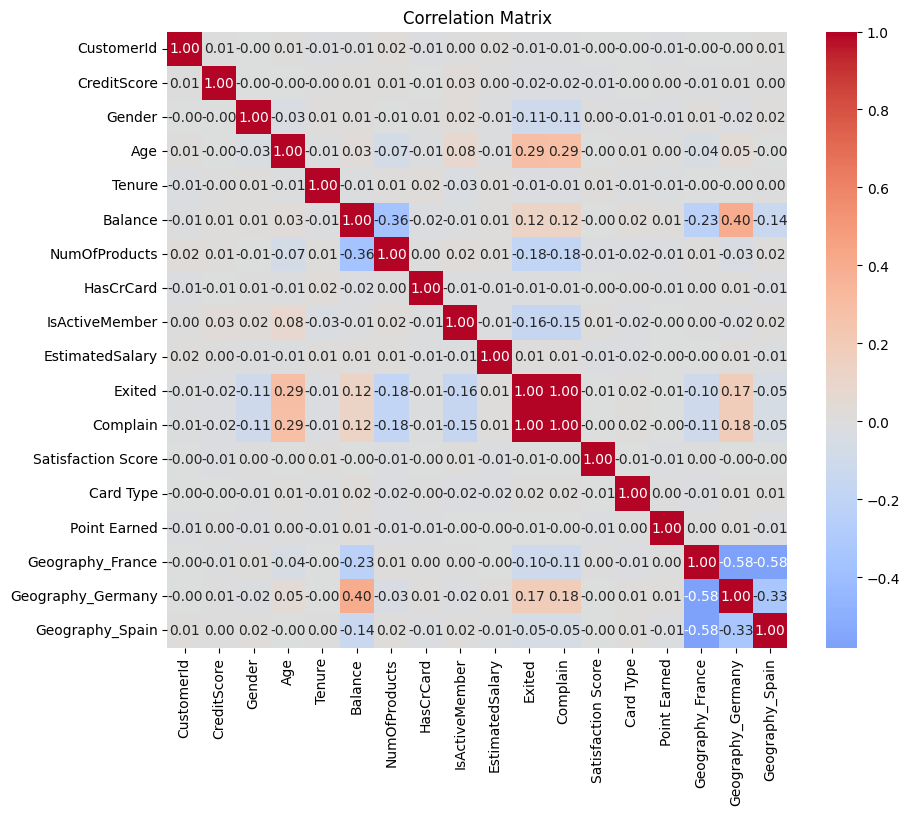


Highly Correlated Feature Pairs (correlation > 0.8 or < -0.8):
('Exited', 'Complain')


In [55]:
# Calculate the correlation matrix for the numerical features
correlation_matrix = df_filtered.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Identify highly correlated features (e.g., with a correlation coefficient > 0.8 or < -0.8)
threshold = 0.8
highly_correlated = np.where((correlation_matrix > threshold) | (correlation_matrix < -threshold))

# Extract the indices of highly correlated features (excluding the diagonal)
highly_correlated_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) 
                           for x, y in zip(*highly_correlated) 
                           if x != y and x < y]  # to avoid duplicate pairs

# Display highly correlated feature pairs
print("\nHighly Correlated Feature Pairs (correlation > 0.8 or < -0.8):")
for pair in highly_correlated_pairs:
    print(pair)

Analyze Class Imbalance

In [ ]:
# calculate the proportions of each class for the target variables
class_proportions = df['Exited'].value_counts(normalize=True) * 100
print(class_proportions)

Exited
0    79.62
1    20.38
Name: proportion, dtype: float64
